# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

72

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train1), "rb") as f:
    TCGA_cyclegan_train1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_train2), "rb") as f:
    TCGA_cyclegan_train2 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test1), "rb") as f:
    TCGA_cyclegan_test1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test2), "rb") as f:
    TCGA_cyclegan_test2 = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train1['train'] + TCGA_cyclegan_train2['train']
TCGA_cyclegan_train_labels = np.concatenate((TCGA_cyclegan_train1['train_label'],TCGA_cyclegan_train2['train_label']))
TCGA_cyclegan_test_data = TCGA_cyclegan_test1['test'] + TCGA_cyclegan_test2['test']
TCGA_cyclegan_test_labels = np.concatenate((TCGA_cyclegan_test1['test_label'],TCGA_cyclegan_test2['test_label']))

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_train_labels:  (3200,)
The shape of TCGA_cyclegan_test_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

253

## Datasets Visualization

<function matplotlib.pyplot.show>

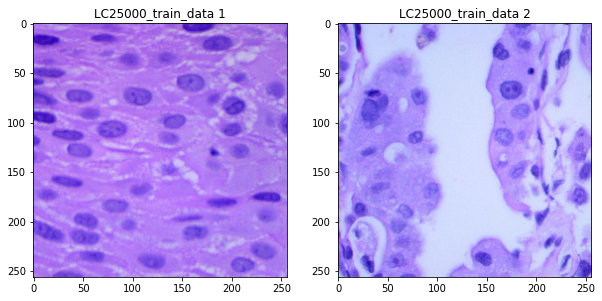

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

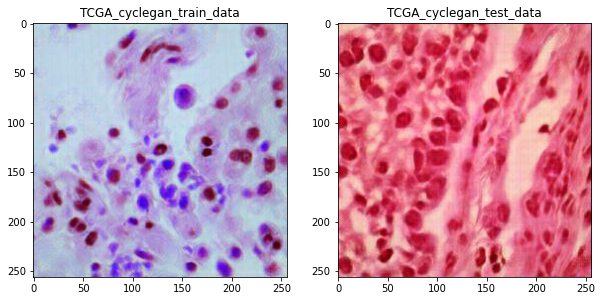

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_cyclegan_train_data, TCGA_cyclegan_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_256.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 512)]     0         
                                                                 
 block5_conv1 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 16, 16, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 8, 8, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_cyclegan_train_lab = one.transform(np.array(TCGA_cyclegan_train_labels).reshape(-1, 1))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data (source) shape: (3200, 256, 256, 3)
TCGA_cyclegan_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1


In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 5s 70ms/step - loss: 2.9443 - acc: 0.3203 - val_loss: 1.4540 - val_acc: 0.1891
Epoch 2/5
50/50 [==============================] - 2s 50ms/step - loss: 1.8875 - acc: 0.4347 - val_loss: 1.5878 - val_acc: 0.1859
Epoch 3/5
50/50 [==============================] - 2s 49ms/step - loss: 1.5804 - acc: 0.4969 - val_loss: 1.6209 - val_acc: 0.2269
Epoch 4/5
50/50 [==============================] - 2s 50ms/step - loss: 1.3382 - acc: 0.5700 - val_loss: 1.8308 - val_acc: 0.2078
Epoch 5/5
50/50 [==============================] - 2s 50ms/step - loss: 1.1145 - acc: 0.6253 - val_loss: 1.8341 - val_acc: 0.2375
Epoch 1/100
50/50 [==============================] - 5s 87ms/step - loss: 1.0272 - acc: 0.6419 - val_loss: 1.9066 - val_acc: 0.2522
Epoch 2/100
50/50 [==============================] - 3s 67ms/step - loss: 0.8667 - acc: 0.6875 - val_loss: 1.9266 - val_acc: 0.2719
Epoch 3/100
50/50 [==============================] - 3s 69ms/step - loss: 0.7910 - acc

### Run 2


In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 6s 71ms/step - loss: 2.5564 - acc: 0.3441 - val_loss: 1.2090 - val_acc: 0.3531
Epoch 2/5
50/50 [==============================] - 2s 49ms/step - loss: 1.9865 - acc: 0.4241 - val_loss: 1.2284 - val_acc: 0.3766
Epoch 3/5
50/50 [==============================] - 2s 49ms/step - loss: 1.6488 - acc: 0.4909 - val_loss: 1.3270 - val_acc: 0.3672
Epoch 4/5
50/50 [==============================] - 2s 50ms/step - loss: 1.4415 - acc: 0.5366 - val_loss: 1.3838 - val_acc: 0.3663
Epoch 5/5
50/50 [==============================] - 2s 49ms/step - loss: 1.2719 - acc: 0.5891 - val_loss: 1.4288 - val_acc: 0.3691
Epoch 1/100
50/50 [==============================] - 6s 86ms/step - loss: 1.1409 - acc: 0.6288 - val_loss: 1.5399 - val_acc: 0.3522
Epoch 2/100
50/50 [==============================] - 3s 66ms/step - loss: 1.0304 - acc: 0.6463 - val_loss: 1.6247 - val_acc: 0.3494
Epoch 3/100
50/50 [==============================] - 3s 67ms/step - loss: 0.8668 - acc

### Run 3


In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 70ms/step - loss: 2.6662 - acc: 0.3422 - val_loss: 1.4598 - val_acc: 0.3713
Epoch 2/5
50/50 [==============================] - 2s 50ms/step - loss: 1.8980 - acc: 0.4306 - val_loss: 1.6382 - val_acc: 0.3728
Epoch 3/5
50/50 [==============================] - 2s 50ms/step - loss: 1.6458 - acc: 0.5053 - val_loss: 1.7276 - val_acc: 0.3466
Epoch 4/5
50/50 [==============================] - 3s 50ms/step - loss: 1.3177 - acc: 0.5725 - val_loss: 1.7898 - val_acc: 0.3403
Epoch 5/5
50/50 [==============================] - 2s 50ms/step - loss: 1.2083 - acc: 0.6097 - val_loss: 1.8209 - val_acc: 0.3288
Epoch 1/100
50/50 [==============================] - 6s 87ms/step - loss: 1.0626 - acc: 0.6438 - val_loss: 1.9456 - val_acc: 0.3219
Epoch 2/100
50/50 [==============================] - 3s 67ms/step - loss: 0.9524 - acc: 0.6784 - val_loss: 1.9135 - val_acc: 0.3350
Epoch 3/100
50/50 [==============================] - 3s 66ms/step - loss: 0.8446 - acc

### Run 4


In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 69ms/step - loss: 2.5193 - acc: 0.4016 - val_loss: 1.6622 - val_acc: 0.4300
Epoch 2/5
50/50 [==============================] - 2s 50ms/step - loss: 2.0215 - acc: 0.4200 - val_loss: 1.8793 - val_acc: 0.4803
Epoch 3/5
50/50 [==============================] - 2s 50ms/step - loss: 1.7385 - acc: 0.4672 - val_loss: 1.8859 - val_acc: 0.4575
Epoch 4/5
50/50 [==============================] - 3s 50ms/step - loss: 1.4751 - acc: 0.5353 - val_loss: 1.9396 - val_acc: 0.4244
Epoch 5/5
50/50 [==============================] - 2s 49ms/step - loss: 1.2873 - acc: 0.5866 - val_loss: 1.9806 - val_acc: 0.3988
Epoch 1/100
50/50 [==============================] - 5s 86ms/step - loss: 1.1566 - acc: 0.6097 - val_loss: 1.9547 - val_acc: 0.3844
Epoch 2/100
50/50 [==============================] - 3s 67ms/step - loss: 0.9683 - acc: 0.6659 - val_loss: 2.0401 - val_acc: 0.3684
Epoch 3/100
50/50 [==============================] - 3s 67ms/step - loss: 0.8873 - acc

### Run 5


In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)


In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
50/50 [==============================] - 4s 69ms/step - loss: 2.5866 - acc: 0.3934 - val_loss: 1.2926 - val_acc: 0.2891
Epoch 2/5
50/50 [==============================] - 2s 50ms/step - loss: 2.0787 - acc: 0.4131 - val_loss: 1.3481 - val_acc: 0.3266
Epoch 3/5
50/50 [==============================] - 2s 49ms/step - loss: 1.7472 - acc: 0.4950 - val_loss: 1.4019 - val_acc: 0.3147
Epoch 4/5
50/50 [==============================] - 2s 50ms/step - loss: 1.5117 - acc: 0.5384 - val_loss: 1.4782 - val_acc: 0.3122
Epoch 5/5
50/50 [==============================] - 2s 50ms/step - loss: 1.3310 - acc: 0.5856 - val_loss: 1.4941 - val_acc: 0.3194
Epoch 1/100
50/50 [==============================] - 5s 83ms/step - loss: 1.1885 - acc: 0.6209 - val_loss: 1.5830 - val_acc: 0.3231
Epoch 2/100
50/50 [==============================] - 3s 67ms/step - loss: 0.9896 - acc: 0.6672 - val_loss: 1.6526 - val_acc: 0.3137
Epoch 3/100
50/50 [==============================] - 3s 67ms/step - loss: 0.8839 - acc

### Result

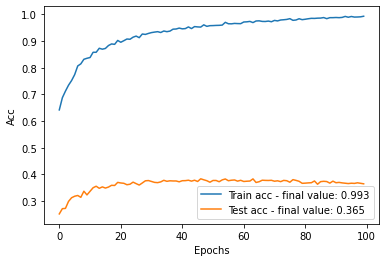

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


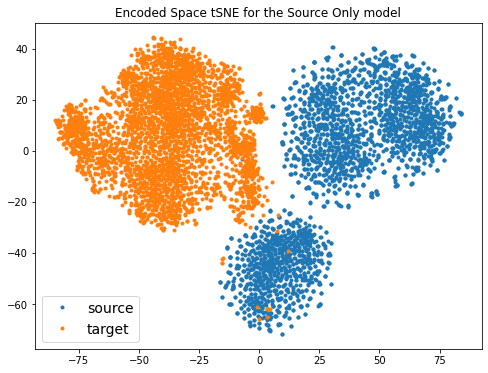

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.182087,0.932663,3.191586,0.364175
std,0.191231,0.070819,0.719961,0.023700
min,0.023285,0.641875,1.906607,0.252187
25%,0.058588,0.913906,2.615752,0.365859
50%,0.118112,0.958125,3.117326,0.372344
75%,0.220776,0.978984,3.725570,0.376563
max,1.027179,0.992813,4.614767,0.383750


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_VGG_256_Adam_0.5e-6_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 14s 29ms/step - loss: 1.4485 - acc: 0.5684 - disc_loss: 3.1442 - val_loss: 1.1595 - val_acc: 0.4894
Epoch 2/150
400/400 [==============================] - 10s 26ms/step - loss: 0.7823 - acc: 0.7222 - disc_loss: 2.8326 - val_loss: 1.3800 - val_acc: 0.4359
Epoch 3/150
400/400 [==============================] - 10s 26ms/step - loss: 0.5554 - acc: 0.7884 - disc_loss: 2.7783 - val_loss: 1.5589 - val_acc: 0.4366
Epoch 4/150
400/400 [==============================] - 10s 26ms/step - loss: 0.4562 - acc: 0.8422 - disc_loss: 2.6806 - val_loss: 1.7610 - val_acc: 0.4247
Epoch 5/150
400/400 [==============================] - 10s 26ms/step - loss: 0.3438 - acc: 0.8719 - disc_loss: 2.5823 - val_loss: 1.8391 - val_acc: 0.4275
Epoch 6/150
400/400 [==============================] - 10s 26ms/step - loss: 0.3001 - acc: 0.8888 - disc_loss: 2.5439 - val_loss: 2.1072 - val_acc: 0.4069
Epoch 7/150
400/400 [==============================] - 10s 26ms/step -

### Run 2

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 13s 28ms/step - loss: 0.0112 - acc: 0.9966 - disc_loss: 14.9635 - val_loss: 38.7967 - val_acc: 0.4638
Epoch 2/150
400/400 [==============================] - 10s 25ms/step - loss: 0.0189 - acc: 0.9947 - disc_loss: 15.1962 - val_loss: 38.8167 - val_acc: 0.4628
Epoch 3/150
400/400 [==============================] - 10s 25ms/step - loss: 0.0281 - acc: 0.9922 - disc_loss: 15.5447 - val_loss: 37.5701 - val_acc: 0.4656
Epoch 4/150
400/400 [==============================] - 10s 25ms/step - loss: 0.1201 - acc: 0.9753 - disc_loss: 19.4426 - val_loss: 30.0786 - val_acc: 0.4644
Epoch 5/150
400/400 [==============================] - 10s 25ms/step - loss: 0.1751 - acc: 0.9591 - disc_loss: 23.9132 - val_loss: 24.8310 - val_acc: 0.4544
Epoch 6/150
400/400 [==============================] - 10s 25ms/step - loss: 0.1463 - acc: 0.9634 - disc_loss: 24.3880 - val_loss: 23.4542 - val_acc: 0.4494
Epoch 7/150
400/400 [==============================] - 10s

### Run 3

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 18s 29ms/step - loss: 1.5664 - acc: 0.5641 - disc_loss: 3.3676 - val_loss: 0.9065 - val_acc: 0.4794
Epoch 2/150
400/400 [==============================] - 11s 27ms/step - loss: 0.8874 - acc: 0.6862 - disc_loss: 2.6665 - val_loss: 1.1166 - val_acc: 0.4450
Epoch 3/150
400/400 [==============================] - 11s 27ms/step - loss: 0.5596 - acc: 0.7947 - disc_loss: 2.4479 - val_loss: 1.2897 - val_acc: 0.4372
Epoch 4/150
400/400 [==============================] - 11s 27ms/step - loss: 0.4417 - acc: 0.8350 - disc_loss: 2.3591 - val_loss: 1.5041 - val_acc: 0.4231
Epoch 5/150
400/400 [==============================] - 11s 27ms/step - loss: 0.3635 - acc: 0.8691 - disc_loss: 2.2911 - val_loss: 1.8010 - val_acc: 0.3972
Epoch 6/150
400/400 [==============================] - 11s 27ms/step - loss: 0.3302 - acc: 0.8831 - disc_loss: 2.3469 - val_loss: 1.9437 - val_acc: 0.3938
Epoch 7/150
400/400 [==============================] - 11s 27ms/step -

### Run 4

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()


optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 16s 31ms/step - loss: 1.5718 - acc: 0.5506 - disc_loss: 3.0043 - val_loss: 0.9384 - val_acc: 0.4916
Epoch 2/150
400/400 [==============================] - 11s 28ms/step - loss: 0.7953 - acc: 0.7225 - disc_loss: 2.8341 - val_loss: 1.1000 - val_acc: 0.4759
Epoch 3/150
400/400 [==============================] - 11s 28ms/step - loss: 0.5602 - acc: 0.7941 - disc_loss: 2.6854 - val_loss: 1.2369 - val_acc: 0.4741
Epoch 4/150
400/400 [==============================] - 11s 28ms/step - loss: 0.4035 - acc: 0.8497 - disc_loss: 2.5936 - val_loss: 1.3968 - val_acc: 0.4619
Epoch 5/150
400/400 [==============================] - 11s 28ms/step - loss: 0.3277 - acc: 0.8775 - disc_loss: 2.5108 - val_loss: 1.5169 - val_acc: 0.4613
Epoch 6/150
400/400 [==============================] - 11s 28ms/step - loss: 0.3183 - acc: 0.8866 - disc_loss: 2.5403 - val_loss: 1.7197 - val_acc: 0.4469
Epoch 7/150
400/400 [==============================] - 11s 28ms/step -

### Run 5

In [ ]:
lr = 0.5e-6
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/150
400/400 [==============================] - 13s 28ms/step - loss: 0.0072 - acc: 0.9981 - disc_loss: 14.8994 - val_loss: 32.6642 - val_acc: 0.4634
Epoch 2/150
400/400 [==============================] - 10s 26ms/step - loss: 0.0105 - acc: 0.9969 - disc_loss: 15.2597 - val_loss: 34.0547 - val_acc: 0.4656
Epoch 3/150
400/400 [==============================] - 10s 25ms/step - loss: 0.0514 - acc: 0.9878 - disc_loss: 17.8339 - val_loss: 32.9190 - val_acc: 0.4753
Epoch 4/150
400/400 [==============================] - 10s 25ms/step - loss: 0.0918 - acc: 0.9762 - disc_loss: 24.5107 - val_loss: 30.3980 - val_acc: 0.4762
Epoch 5/150
400/400 [==============================] - 10s 25ms/step - loss: 0.0941 - acc: 0.9778 - disc_loss: 26.2970 - val_loss: 29.0053 - val_acc: 0.4697
Epoch 6/150
400/400 [==============================] - 10s 25ms/step - loss: 0.0938 - acc: 0.9772 - disc_loss: 26.6105 - val_loss: 27.6907 - val_acc: 0.4616
Epoch 7/150
400/400 [==============================] - 10s

### Result

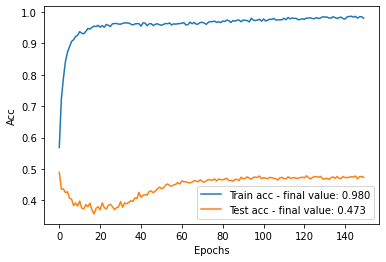

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


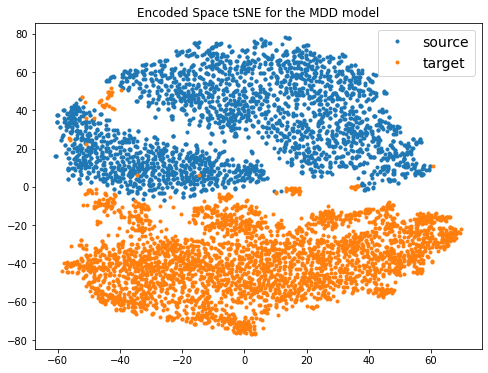

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.133716,0.960012,7.638737,6.547000,0.444702
std,0.136863,0.045067,4.186161,2.333259,0.035725
min,0.050930,0.568438,1.124498,1.159471,0.356875
25%,0.082360,0.961016,4.336324,4.924567,0.419609
50%,0.115855,0.967344,7.437560,6.973376,0.463437
75%,0.138455,0.977813,10.746941,8.323272,0.471719
max,1.448461,0.986562,20.494131,11.712184,0.489375


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_VGG_256_RMS_0.5e-6_g1_cyclegan.csv")

In [ ]:
import gc
gc.collect()

509